In [1]:
# Install Depth Pro
!git clone https://github.com/apple/ml-depth-pro
%cd ml-depth-pro
!pip install -e .
!source get_pretrained_models.sh

Cloning into 'ml-depth-pro'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 48 (delta 9), reused 2 (delta 2), pack-reused 22 (from 2)
Receiving objects: 100% (48/48), 2.50 MiB | 16.22 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/kaggle/working/ml-depth-pro
Obtaining file:///kaggle/working/ml-depth-pro
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 45.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Install YOLOv11 dependencies
!pip install ultralytics opencv-python pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00a 0:00:01


In [3]:
# Libraries
from PIL import Image
import numpy as np
from src import depth_pro
import matplotlib.pyplot as plt
import torch
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Load Depth Pro model
depth_model, transform = depth_pro.create_model_and_transforms()
depth_model.eval()

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [5]:
# Load image
image_path = "/kaggle/input/myimage1/food2.jpg"
image = Image.open(image_path).convert("RGB")
np_image = np.array(image)

In [6]:
# Preprocess and predict depth
image_tensor, _, f_px = depth_pro.load_rgb(image_path)
image_tensor = transform(image_tensor)
prediction = depth_model.infer(image_tensor, f_px=f_px)
depth_map = prediction["depth"].detach().cpu().numpy().squeeze().astype(np.float16)

In [7]:
# Load YOLOv11n segmentation model
model = YOLO("/kaggle/input/model2/best(2).pt")

In [8]:
# Inference
results = model(image_path)[0]
masks = results.masks.data.cpu().numpy()  # Shape: [N, H, W]
names = results.names
boxes = results.boxes.data.cpu().numpy()  # [x1, y1, x2, y2, conf, class]


image 1/1 /kaggle/input/myimage1/food2.jpg: 640x480 1 Beef curry, 1 Rice, 58.5ms
Speed: 12.7ms preprocess, 58.5ms inference, 449.0ms postprocess per image at shape (1, 3, 640, 480)


In [9]:
# Resize depth map to match YOLO mask resolution
depth_map_resized = cv2.resize(depth_map, (masks.shape[2], masks.shape[1]), interpolation=cv2.INTER_NEAREST)
original_np = np.array(image)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


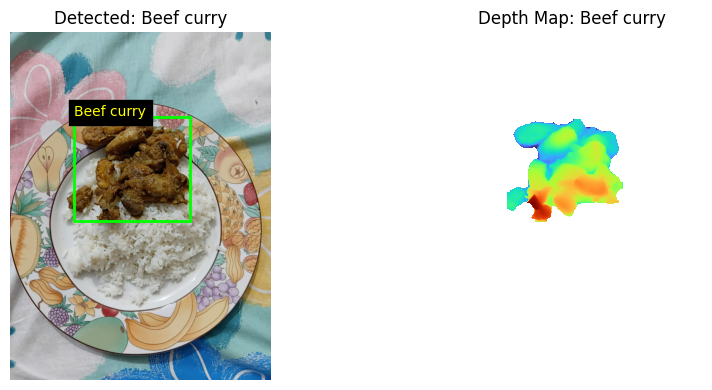


[Beef curry]
- Pixels with depth: 28376
- Representative Depth (mean): 0.682 meters
- Sample Depth Values: [    0.73438     0.73535     0.73584     0.73584     0.73047     0.71436     0.70947     0.70996     0.71729     0.72852]


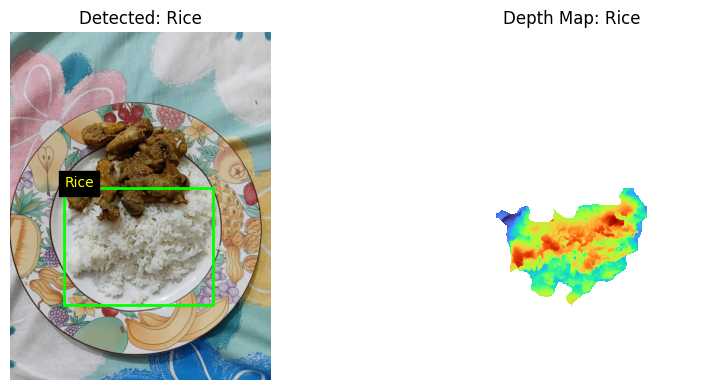


[Rice]
- Pixels with depth: 34926
- Representative Depth (mean): 0.676 meters
- Sample Depth Values: [    0.68604     0.69092     0.69141     0.69141     0.69287     0.69385     0.69189     0.69092     0.69092     0.69043]


In [10]:
# Depth for each detected object
food_depths = {}

for i, mask in enumerate(masks):
    x1, y1, x2, y2, conf, cls_id = boxes[i]
    class_name = names[int(cls_id)]

    # Get masked depth for the object
    masked_depth = np.where(mask, depth_map_resized, np.nan)

    # Handle multiple objects with same label
    label = class_name
    if label in food_depths:
        index = 2
        while f"{label}_{index}" in food_depths:
            index += 1
        label = f"{label}_{index}"

    # Save masked depth map
    food_depths[label] = masked_depth

    # Get valid depth values
    valid_depths = masked_depth[~np.isnan(masked_depth)]
    if len(valid_depths) == 0:
        print(f"[{label}] - No valid depth found.")
        continue

    # Calculate mean depth as representative
    mean_depth = np.nanmean(valid_depths)

    # Visualization
    inv_depth = 1 / np.clip(masked_depth, 1e-3, 10)
    inv_depth_normalized = (inv_depth - np.nanmin(inv_depth)) / (np.nanmax(inv_depth) - np.nanmin(inv_depth))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_np)
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='lime', facecolor='none', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1 - 5, label, color='yellow', fontsize=10, backgroundcolor="black")
    plt.title(f"Detected: {label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(inv_depth_normalized, cmap="turbo")
    plt.title(f"Depth Map: {label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Print depth info
    print(f"\n[{label}]")
    print(f"- Pixels with depth: {len(valid_depths)}")
    print(f"- Representative Depth (mean): {mean_depth:.3f} meters")
    print(f"- Sample Depth Values: {valid_depths[:10]}")
